In [1]:
import copy
from typing import Optional, List

from fastai.distributed import *
from fastai.vision.all import *

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor
from torchvision import transforms

from scipy.spatial import distance
import numpy as np

from models.encoder import EncoderModule
from models.backbone import Backbone, NoBackbone

from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [3]:
from PIL import Image
import requests

In [19]:
w = width = 256
h = height = 256
grid_l=32
pf="1"
alpha=1

transform = T.Compose([
T.Resize((h,w)),
T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
])

Input shape: torch.Size([1, 3, 256, 256])


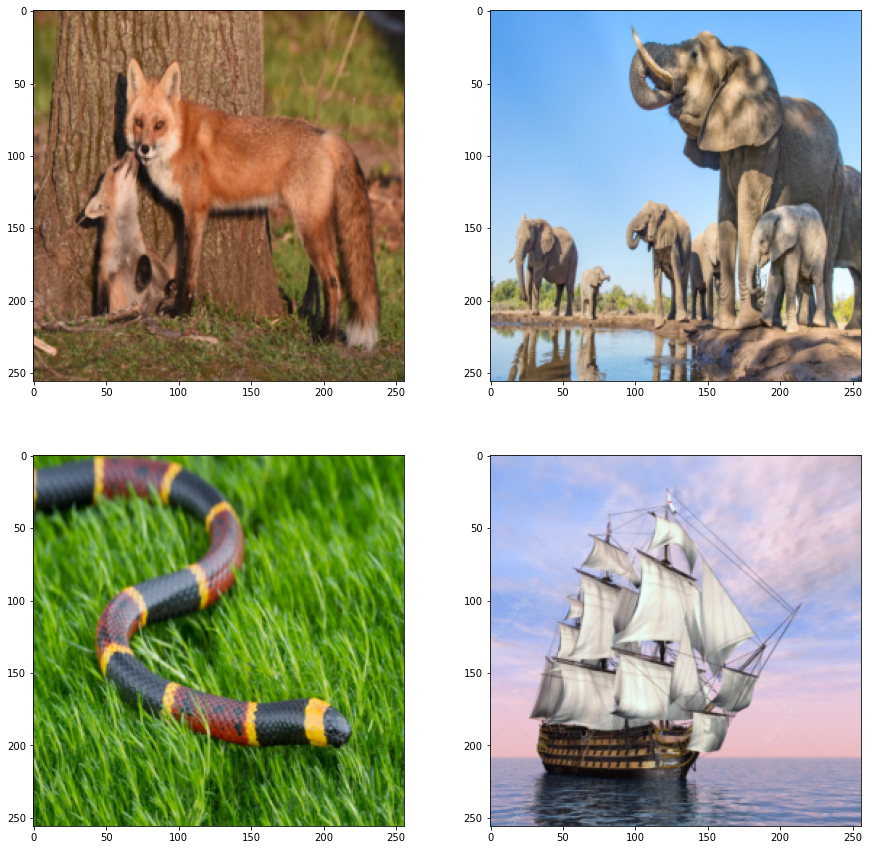

In [5]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
url3 = 'https://cdn.britannica.com/90/206390-050-69486F6E/eastern-coral-snake.jpg'
url4 = 'https://st2.depositphotos.com/1020917/7268/i/950/depositphotos_72688965-stock-photo-hms-victory.jpg'
im = Image.open(requests.get(url, stream=True).raw)
img = transform(im).unsqueeze(0)
im2 = Image.open(requests.get(url2, stream=True).raw)
img2 = transform(im2).unsqueeze(0)
im3 = Image.open(requests.get(url3, stream=True).raw)
img3 = transform(im3).unsqueeze(0)
im4 = Image.open(requests.get(url4, stream=True).raw)
img4 = transform(im4).unsqueeze(0)
batch= torch.cat((img, img2, img3, img4), 0)
print("Input shape:", img.shape)
plt.subplots(2,2,figsize=(15,15))
plt.subplot(221)
plt.imshow(batch[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(batch[1].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(batch[2].cpu().permute(1, 2, 0))
plt.subplot(224)
plt.imshow(batch[3].cpu().permute(1, 2, 0))

In [122]:
class CuratingOfAttentionLoss(nn.Module):
    def __init__(self, width=32, height=32, grid_l=2):
        super().__init__()
        self.grid_l = grid_l
        self.width = width
        self.height = height
        self.grids_list = self.grid_list(self.width, self.height, self.grid_l)
        self.grids_matrix = self.grid_matrix(self.width, self.height, self.grid_l)
        
        
    def grid_list(self, width, height, grid_l): #COMPUTED ONCE BEFORE TRAINING
        w = width
        h = height
        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l
        qtd_grids = qt_hor_grids*qt_ver_grids
        c = 0
        grids_list = []
        for i in range(qtd_grids):
            hor_pos = i//qt_hor_grids
            ver_pos = c
            c = c+1
            grid = [hor_pos,ver_pos]
            grids_list.append(grid)
            if c == qt_ver_grids:
                c=0
        return grids_list
        
        
    def grid_matrix(self, width, height, grid_l):

        w = width
        h = height
        len_input_seq = h*w
        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l


        grid_list = []
        for i in range(h):
            row_grid_list = []
            preliminar_ver_grid = i//grid_l
            if preliminar_ver_grid != 0:
                preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

            for h in range(w):
                preliminar_grid = h//grid_l+preliminar_ver_grid
                row_grid_list.append(preliminar_grid)

            grid_list.append(row_grid_list)
        grid_matrix = torch.tensor(np.array(grid_list))

        return grid_matrix
        
        
    def img_patches(self, batch, grid_l):
        #torch.Tensor.unfold(dimension, size, step)
        #slices the images into grid_l*grid_l size patches
        patches = batch.data.unfold(1, 3, 3).unfold(2, grid_l, grid_l).unfold(3, grid_l, grid_l)
        a, b, c, d, e, f, g = patches.shape
        patches = patches.reshape(a, c, d, e, f, g)
        #print(patches.shape)
        return patches


    def grid_gram_matrix(self, patches):

        a, b, c, d, e, f = patches.shape
        # a=batch size
        # b=horizontal patches
        # c = vertical patches
        # d=number of feature maps
        # (e,f)=dimensions of a f. map (N=e*f)

        features = patches.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
        #print(features.shape)
        # compute the gram product

        G = torch.mm(features[0], features[0].t())

        for i in range(1,a*b*c):
            g = torch.mm(features[i], features[i].t())
            G= torch.cat((G, g), 0)


        G = G.div(d * e * f).reshape(a, b, c, d, d)

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.

        return G



    def gram_dist_matrix(self, batch, grid_l):
        patches = self.img_patches(batch, grid_l)
        #print(patches.shape)
        Grid = self.grid_gram_matrix(patches)
        #print(Grid.shape)
        bs = batch.shape[0]
        #print(bs)
        MSE = nn.MSELoss()

        Grid = Grid.reshape(Grid.shape[0],Grid.shape[1]*Grid.shape[2],Grid.shape[3],Grid.shape[4])
        gmg_shape = Grid.shape
        #print(gmg_shape)
        
        
        mse_grid = []
        for k in range(gmg_shape[0]):
            dist_grid = []
            for g in range(gmg_shape[1]):
                dist_pair_list = []
                for n in range(gmg_shape[1]):
                    dist_pair_list.append(MSE(Grid[k][g], Grid[k][n]))
                dist_grid.append(dist_pair_list)
            mse_grid.append(dist_grid)

        dist_matrix = torch.tensor(np.array(mse_grid))
        for i in range(bs):
            dist_matrix[i] -= dist_matrix[i].min()
            dist_matrix[i] /= dist_matrix[i].max()

        return dist_matrix


    def new_gram_dist_matrix(self, batch, grid_l):
        patches = self.img_patches(batch, grid_l)
        #print(patches.shape)
        Grid = self.grid_gram_matrix(patches)
        #print(Grid.shape)
        bs = batch.shape[0]
        #print(bs)
        MSE = nn.MSELoss()

        gbd = 32//4 #gbd = grids by dimension

        mse_grid = []
        for k in range(bs):
            dist_grid = []
            dist_block = []
            for g in range(len(self.grids_list)):
                dist_pair_list = []
                dist_pair_line = []
                for n in range(len(self.grids_list)):
                    #print(g, n)
                    dist = MSE(Grid[k][self.grids_list[g][0]][self.grids_list[g][1]], Grid[k][self.grids_list[n][0]][self.grids_list[n][1]])
                    for l in range(self.grid_l):
                        dist_pair_line.append(dist)
                    if (n+1)%gbd == 0:
                        #print(n)
                        a = []
                        for i in range(self.grid_l):
                            a = a + dist_pair_line
                        #print(a)
                        dist_pair_list = dist_pair_list + a
                        dist_pair_line = []

                for l in range(self.grid_l):
                    dist_block.append(dist_pair_list)

                if (g+1)%gbd == 0:
                    b =[]
                    for z in range(self.grid_l):
                        b = b + dist_block
                    dist_grid = dist_grid + b
                    dist_block = []

            mse_grid.append(dist_grid)
            #print("Image finished")
        dist_matrix = torch.tensor(np.array(mse_grid))
        #print("Matrix finished")
        #print(dist_matrix.shape)

        for i in range(bs):
            dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
            dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
            dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
            dist_matrix[i] = dist_matrix[i].view(1, self.width*self.height, self.width*self.height)

        return dist_matrix
    
    
    #######################################3
    ########################################3
    #######################################33



    def penalty_factor(self, dist_matrix, penalty_factor="1", alpha=1):
        if penalty_factor == "1" or penalty_factor =="distraction":
            pf_matrix = ((dist_matrix+1))**alpha
            return pf_matrix
        if penalty_factor == "2" or penalty_factor =="misdirection":
            pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
            return pf_matrix


    def penalty_matrix(self, width, height, grid_matrix, dist_matrix, grid_l):
        bs,_,_ = dist_matrix.shape
        pep = []
        print(dist_matrix.shape)
        for s in range(bs):
            pf_matrix = self.penalty_factor(dist_matrix[s], penalty_factor="1", alpha=1)
            w = width
            h = height

            qt_hor_grids = w//grid_l
            qt_ver_grids = h//grid_l
            qtd_grids = qt_hor_grids*qt_ver_grids

            penalty_mask = []
            for i in range(qtd_grids):
                ref_column = pf_matrix[i]
                p_matrix = grid_matrix.type(torch.FloatTensor)
                for j in range(1,len(ref_column)):
                    #print(float(j))
                    p_matrix[p_matrix==j]=float(ref_column[j])
                p_matrix[p_matrix==0]=float(ref_column[0])
                penalty_mask.append(p_matrix)

            #print(len(penalty_mask))    

            penalty_enc = []
            for i in range(h):
                penalty_row = []
                for j in range(w):
                    #print(grid_matrix[i,j])
                    #print(penalty_mask[grid_matrix[i,j]].shape)
                    penalty_row.append(penalty_mask[grid_matrix[i,j]])
                    #print(len(penalty_row))
                generic_tensor = Tensor(h,w)
                penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
                penalty_enc.append(penalty_row_tensor)
                #print(penalty_row_tensor.shape)
                #break

            b = torch.Tensor(h, w, h, w)
            c=torch.cat(penalty_enc, out=b)
            c = c.view(h, w, h, w)
            pep.append(c)

        d = torch.Tensor(bs, h, w, h, w)
        penalty_encoding_pattern = torch.cat(pep, out=d)
        penalty_encoding_pattern = penalty_encoding_pattern.view(bs, h, w, h, w)

        return penalty_encoding_pattern
        
    def forward(self, batch):
        
        start = timer()
        dist_matrix = self.gram_dist_matrix(batch, self.grid_l)
        print("DM time:", timer()-start) 
        
        #start = timer()
        #dist_matrix2 = self.new_gram_dist_matrix(batch, self.grid_l)
        #pnt_matrix = self.penalty_matrix(self.width, self.height, self.grids_matrix, dist_matrix, self.grid_l)
        #print("DM2 time:", timer()-start) 
        #pnt_matrix = 1
        #Latt = torch.sum(sattn)
        
        return dist_matrix#, dist_matrix2#Latt

In [123]:
Latt = CuratingOfAttentionLoss(256,256,32).to(device)

In [124]:
start = timer()
pmtx = Latt(batch)
print("Total time:", timer()-start) 

torch.Size([4, 64, 3, 3])
DM time: 0.5694169170164969
Total time: 0.57029316900298


In [31]:
list_of_grids = Latt.grid_list(w, h, grid_l)
len(list_of_grids)

64

torch.Size([256, 256])


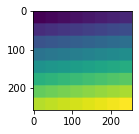

In [34]:
matrix_of_grids = Latt.grid_matrix(w, h, grid_l)
plt.subplot(221)
print(matrix_of_grids.shape)
plt.imshow(matrix_of_grids)

torch.Size([4, 8, 8, 3, 32, 32])


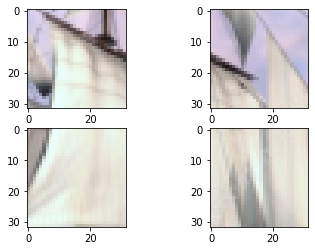

In [60]:
patches = Latt.img_patches(batch, grid_l)
print(patches.shape)
plt.subplot(221)
plt.imshow(patches[3][2][3].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(patches[3][2][4].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(patches[3][3][3].cpu().permute(1, 2, 0))
plt.subplot(224)
plt.imshow(patches[3][3][4].cpu().permute(1, 2, 0))

torch.Size([4, 8, 8, 3, 3])


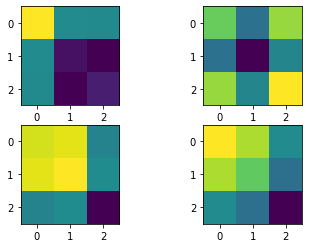

In [59]:
gram_matrix_grid = Latt.grid_gram_matrix(patches)
print(gram_matrix_grid.shape)
plt.subplot(221)
plt.imshow(gram_matrix_grid[3][2][3])
plt.subplot(222)
plt.imshow(gram_matrix_grid[3][2][4])
plt.subplot(223)
plt.imshow(gram_matrix_grid[3][3][3])
plt.subplot(224)
plt.imshow(gram_matrix_grid[3][3][4])

In [83]:
bs = batch.shape[0]
MSE = nn.MSELoss()
gmshape = gram_matrix_grid.shape
new_gmg = gram_matrix_grid.reshape(gmshape[0],gmshape[1]*gmshape[2],gmshape[3],gmshape[4])
gmg_shape = new_gmg.shape
print(gmg_shape)

torch.Size([4, 64, 3, 3])


In [113]:
mse_grid = []
for k in range(gmg_shape[0]):
    dist_grid = []
    for g in range(gmg_shape[1]):
        dist_pair_list = []
        for n in range(gmg_shape[1]):
            dist_pair_list.append(MSE(new_gmg[k][g], new_gmg[k][n]))
        dist_grid.append(dist_pair_list)
    mse_grid.append(dist_grid)

dist_matrix = torch.tensor(np.array(mse_grid))
for i in range(bs):
    dist_matrix[i] -= dist_matrix[i].min()
    dist_matrix[i] /= dist_matrix[i].max()

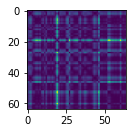

In [116]:
plt.subplot(221)
plt.imshow(dist_matrix[2])

In [121]:
print(dist_matrix[3].max())
print(dist_matrix[3].min())

tensor(1.)
tensor(0.)


In [115]:
for i in range(bs):
    #dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
    dist_matrix[i] -= dist_matrix[i].min()
    dist_matrix[i] /= dist_matrix[i].max()
    #dist_matrix[i] = dist_matrix[i].view(1, gmg_shape[1], gmg_shape[1])

In [75]:
new_gmg = gram_matrix_grid.reshape(4,64,3,3)

In [82]:
new_gmg[0][23] == gram_matrix_grid[0][2][7]

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

In [ ]:
for i in range(bs):
    dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
    dist_matrix[i] -= dist_matrix[i].min()
    dist_matrix[i] /= dist_matrix[i].max()
    dist_matrix[i] = dist_matrix[i].view(1, len(self.grids_list), len(self.grids_list))

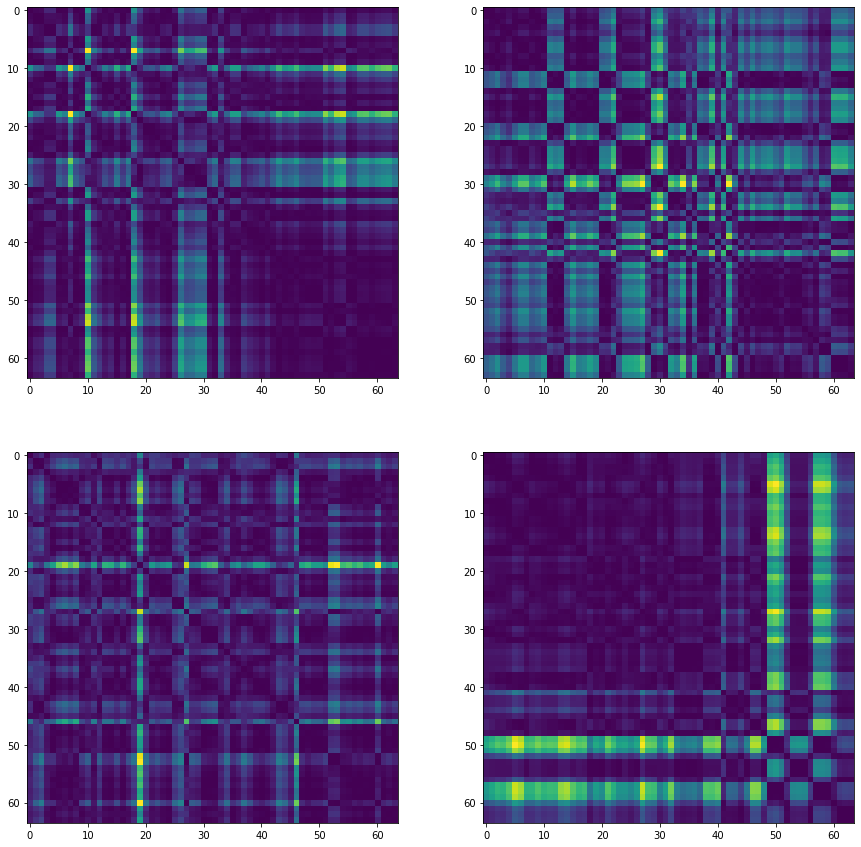

In [125]:
plt.subplots(2,2,figsize=(15,15))
plt.subplot(221)
plt.imshow(pmtx[0])
plt.subplot(222)
plt.imshow(pmtx[1])
plt.subplot(223)
plt.imshow(pmtx[2])
plt.subplot(224)
plt.imshow(pmtx[3])